# Net Generation

In [3]:
%%capture
# Import necessary packages
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Data gathered from the yearly workbooks https://github.com/acep-uaf/ak-energy-statistics-2011_2021/tree/main/workbooks
# These data reflect manual additions. Note data from 2011-2013 is in final form, where 2014 onward is considered "early release, subject to change"

# Import required data
d = pd.read_csv(os.path.join(os.curdir, 'data','net-generation-by-fuel-type.csv')) # import net generation data by fuel type, 2011 to 2021
cw = pd.read_csv(os.path.join(os.curdir, 'data','region-crosswalk.csv')) # import the AEA to ACEP energy region key

# Remove entries without an data source. These indicate there was no data present.
d = d[d['source'].notna()]

# Region label
d['acep_energy_region'] = d['aea_energy_region'].map(pd.Series(cw['acep_energy_region'].values,index=cw['aea_energy_region']).to_dict()) # map the acep energy region to the aea region based on the key

# Import the color schemes
schemes = json.load(open(os.path.join(os.curdir, 'color-schemes.json'))) # import the color schemes

## Statewide Charts

In [5]:
# This section creates the "Electricity generation by region" graph which shows yearly total net generation by ACEP energy region

# Calculating total net generation across fuel types
fuel_types = ['oil','gas','coal','hydro','wind','solar','storage','other'] # list of fuel types to aggregate across
d['total'] = d[fuel_types].sum(axis=1) # create a column that adds the fuel types
d['total_gwh'] = d['total'] / 1000 # create a total column represented as GWh instead of MWh

### Total Net Generation by Region

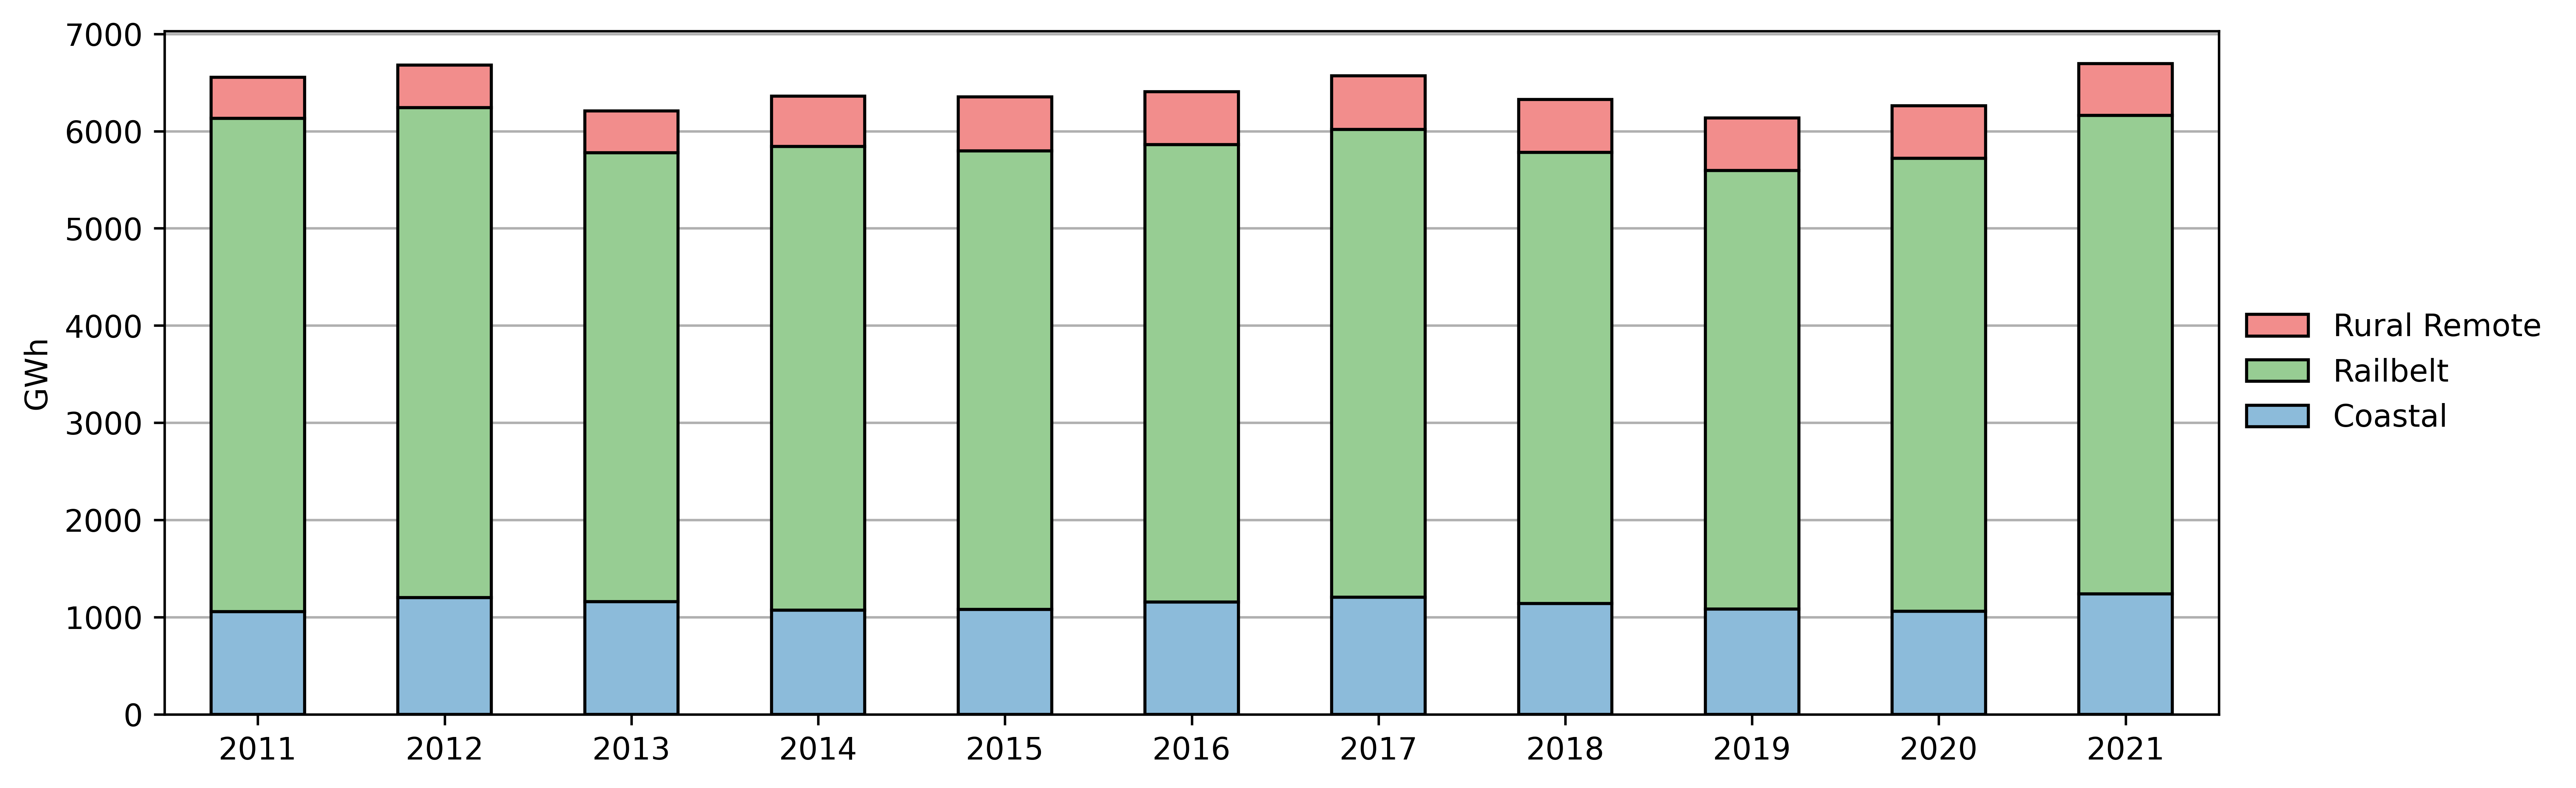

In [6]:
# Plotting net generation by year and region
fig, ax = plt.subplots(figsize=(6.5,4), layout='none')
fig.set_dpi(600)
pd.pivot_table(d, index='year',columns='acep_energy_region',values='total_gwh',aggfunc='sum').plot(kind='bar',stacked=True, color=schemes['energy_regions'], rot=0, edgecolor='black', linewidth=1, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('GWh')
ax.grid(axis ='y')
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels),bbox_to_anchor = (1,0.5),loc='center left', frameon=False,ncol=1)
plt.subplots_adjust(right=1.55)
filename = 'gen-statewide'
plt.savefig(os.path.join(os.curdir, 'figures', filename + '.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(os.curdir, 'figures', filename + '.png'), bbox_inches='tight')

In [7]:
# Producing the pivot table for the data appendix
e = pd.pivot_table(d, index='year',columns='acep_energy_region',values='total_gwh',aggfunc='sum').reset_index() # pivot table
e.columns = e.columns.str.title() # pretty up the headers
e.rename(columns={'year':'Year','Coastal':'Coastal (GWh)','Railbelt':'Railbelt (GWh)','Rural Remote':'Rural Remote (GWh)'}, inplace=True) # add units to headers
e['Statewide (GWh)'] = e[e.columns.to_list()[1:]].sum(axis=1) # creating a total column
e = round(e,2) # rounding off the data
e.to_csv(os.path.join(os.curdir,'tables',filename+'.csv'), index=False) # export the table as a csv to the tables folder

In [8]:
# In-text calculations:
print(
    'Average Coastal Gen (GWh):', round(e['Coastal (GWh)'].mean()), os.linesep,
    'Average Railbelt Gen (GWh):', round(e['Railbelt (GWh)'].mean()), os.linesep,
    'Average Rural Remote Gen (GWh):', round(e['Rural Remote (GWh)'].mean()), os.linesep,
)


Average Coastal Gen (GWh): 1131 
 Average Railbelt Gen (GWh): 4772 
 Average Rural Remote Gen (GWh): 509 



### Percentage Point Changes by Fuel Type

In [9]:
# Creating a percentage point change table for plotting and data appendix
#   - Note that these calculations are done sans categories: 'other', 'storage'
#       - Storage would show up as negative value due to non-perfect efficiency
#       - There is no 'other' generation between data years 2011 and 2021, but other is a category throughout the years
#   - This means interpretation is restricted to how each region used Hydro, Oil, Solar, and Wind

# Shaping the data
p = pd.pivot_table(d[d['year'].isin([2011,2021])], index=['acep_energy_region','year'], values=fuel_types, aggfunc='sum') # pivot table summing total net gen by region, year, and fuel type
p.drop(['other','storage'], axis=1, inplace=True) # removing storage since it doesn't make a ton of sense and other there is no change
p = p[p.columns.to_list()].div(p[p.columns.to_list()].sum(axis=1), axis=0) # calculate the share to which each fuel type contributes to the total in each row

In [10]:
# Calculating percentage point changes for these specific fuel types
p = p.T # transpose the table for column-wise calculations
p[('Coastal', 'Delta')] = (p[('Coastal', 2021)] - p[('Coastal', 2011)])*100 # percentage point change in generation by fuel type
p[('Railbelt', 'Delta')] = (p[('Railbelt', 2021)] - p[('Railbelt', 2011)])*100 # percentage point change in generation by fuel type
p[('Rural Remote', 'Delta')] = (p[('Rural Remote', 2021)] - p[('Rural Remote', 2011)])*100 # percentage point change in generation by fuel type
p.drop(p.columns.to_list()[:6], axis=1, inplace=True) # dropping irrelevant columns
p.columns = p.columns.droplevel(1) # dropping the 'delta' multi-index
p = p.T.reset_index() # transposing back for plotting
p.columns = p.columns.str.title() # capitalizing headers for easier plotting
p.rename(columns={'Acep_Energy_Region':'Energy Region'},inplace=True) # renaming column
p.set_index('Energy Region', inplace=True) # set the energy region as the index
p = p.reindex(['Rural Remote','Railbelt','Coastal']) # reorder the index for better plotting

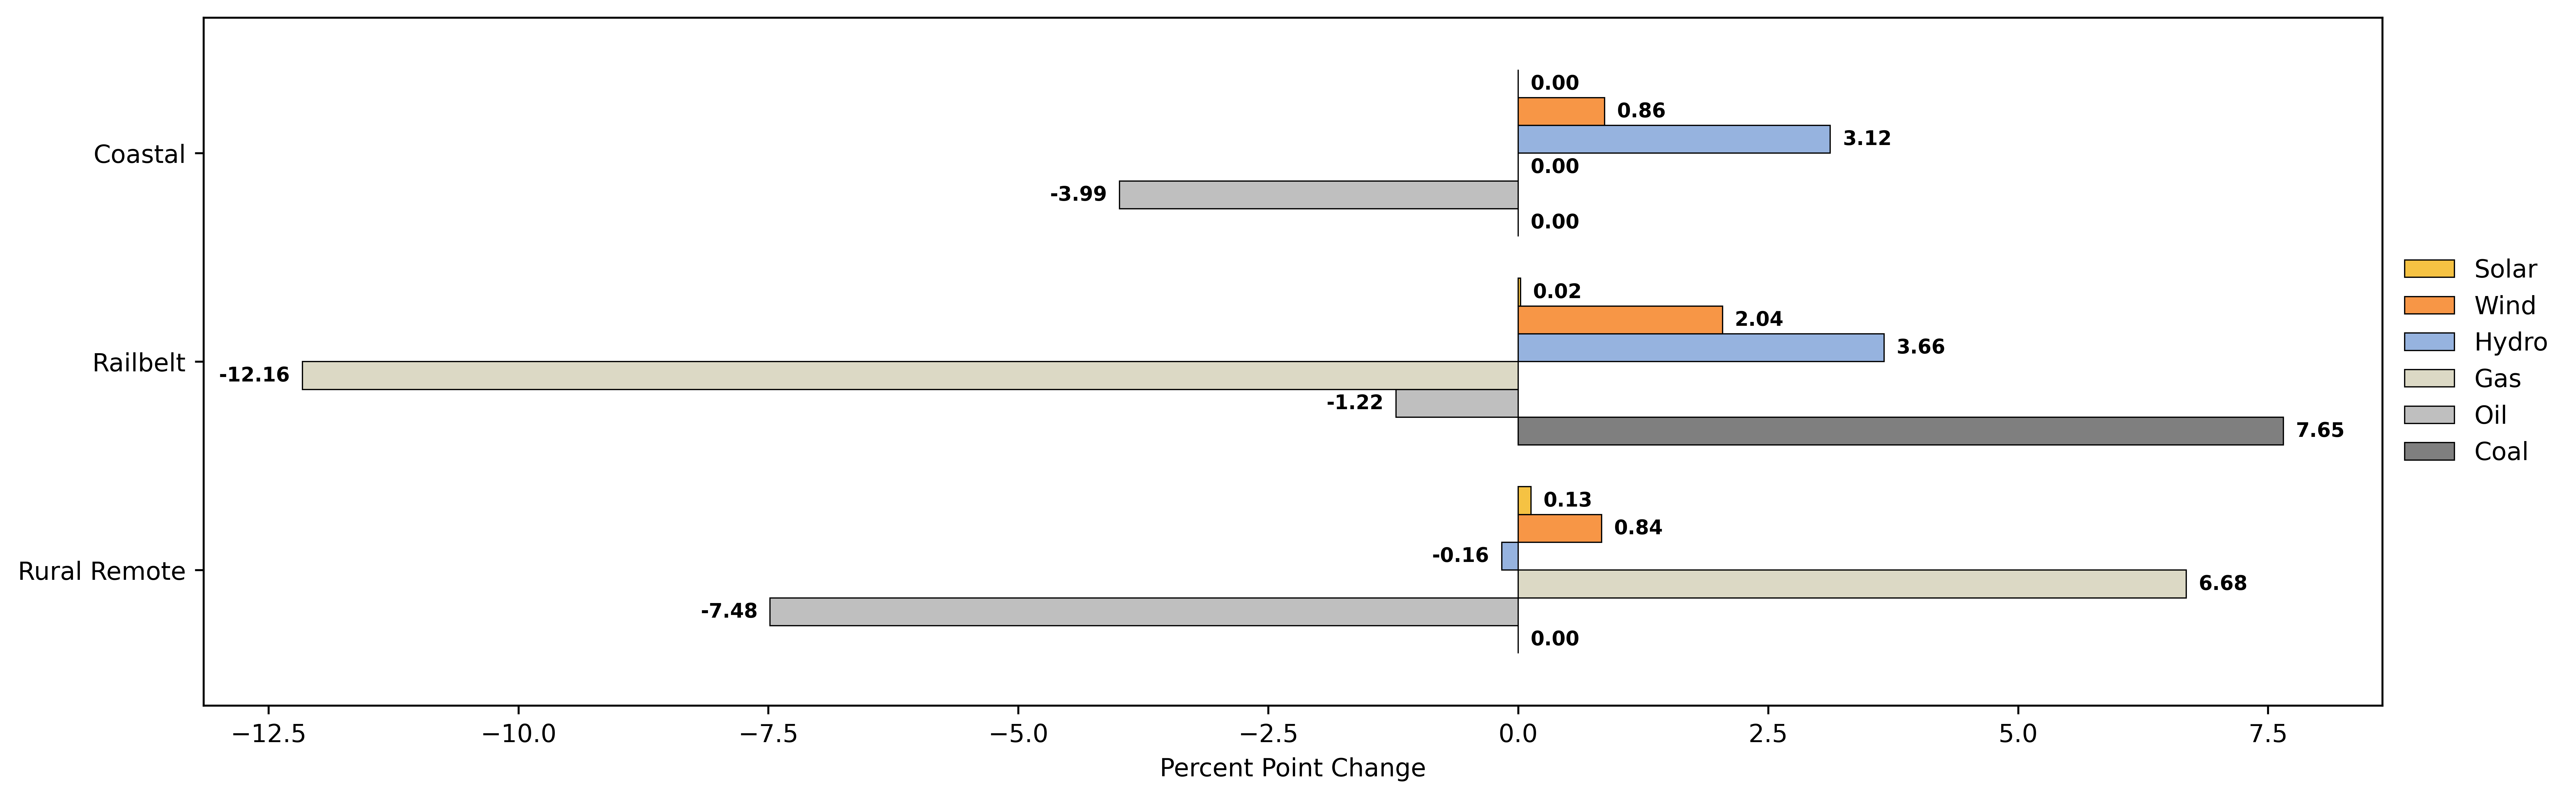

In [11]:
# Plotting the percentage point changes by fuel type chart
resource_list = ['Coal','Oil','Gas','Hydro','Wind','Solar'] # list of resources to plot

# Plot
fig, ax = plt.subplots(figsize=(6.5,5), layout='none')
fig.set_dpi(600)
p.plot(kind='barh', y=resource_list, rot=0, width=.8, align='center', edgecolor='black',linewidth=0.5, color=schemes['fuel_types'], ax=ax) #y=reversed(resource_list)
for container in ax.containers:
    ax.bar_label(container,fmt='{:.2f}', fontsize=8, fontweight='bold',color='black', label_type='edge', padding=5)
ax.set_xlabel('Percent Point Change')
ax.set_ylabel('')
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels),bbox_to_anchor = (1,0.5),loc='center left', frameon=False,ncol=1)
plt.subplots_adjust(right=2)
filename = os.path.join(os.curdir, 'figures','net-gen-pct-point-deltas')
plt.savefig(filename + '.pdf', bbox_inches='tight')
plt.savefig(filename + '.png', bbox_inches='tight')

## Regional Charts

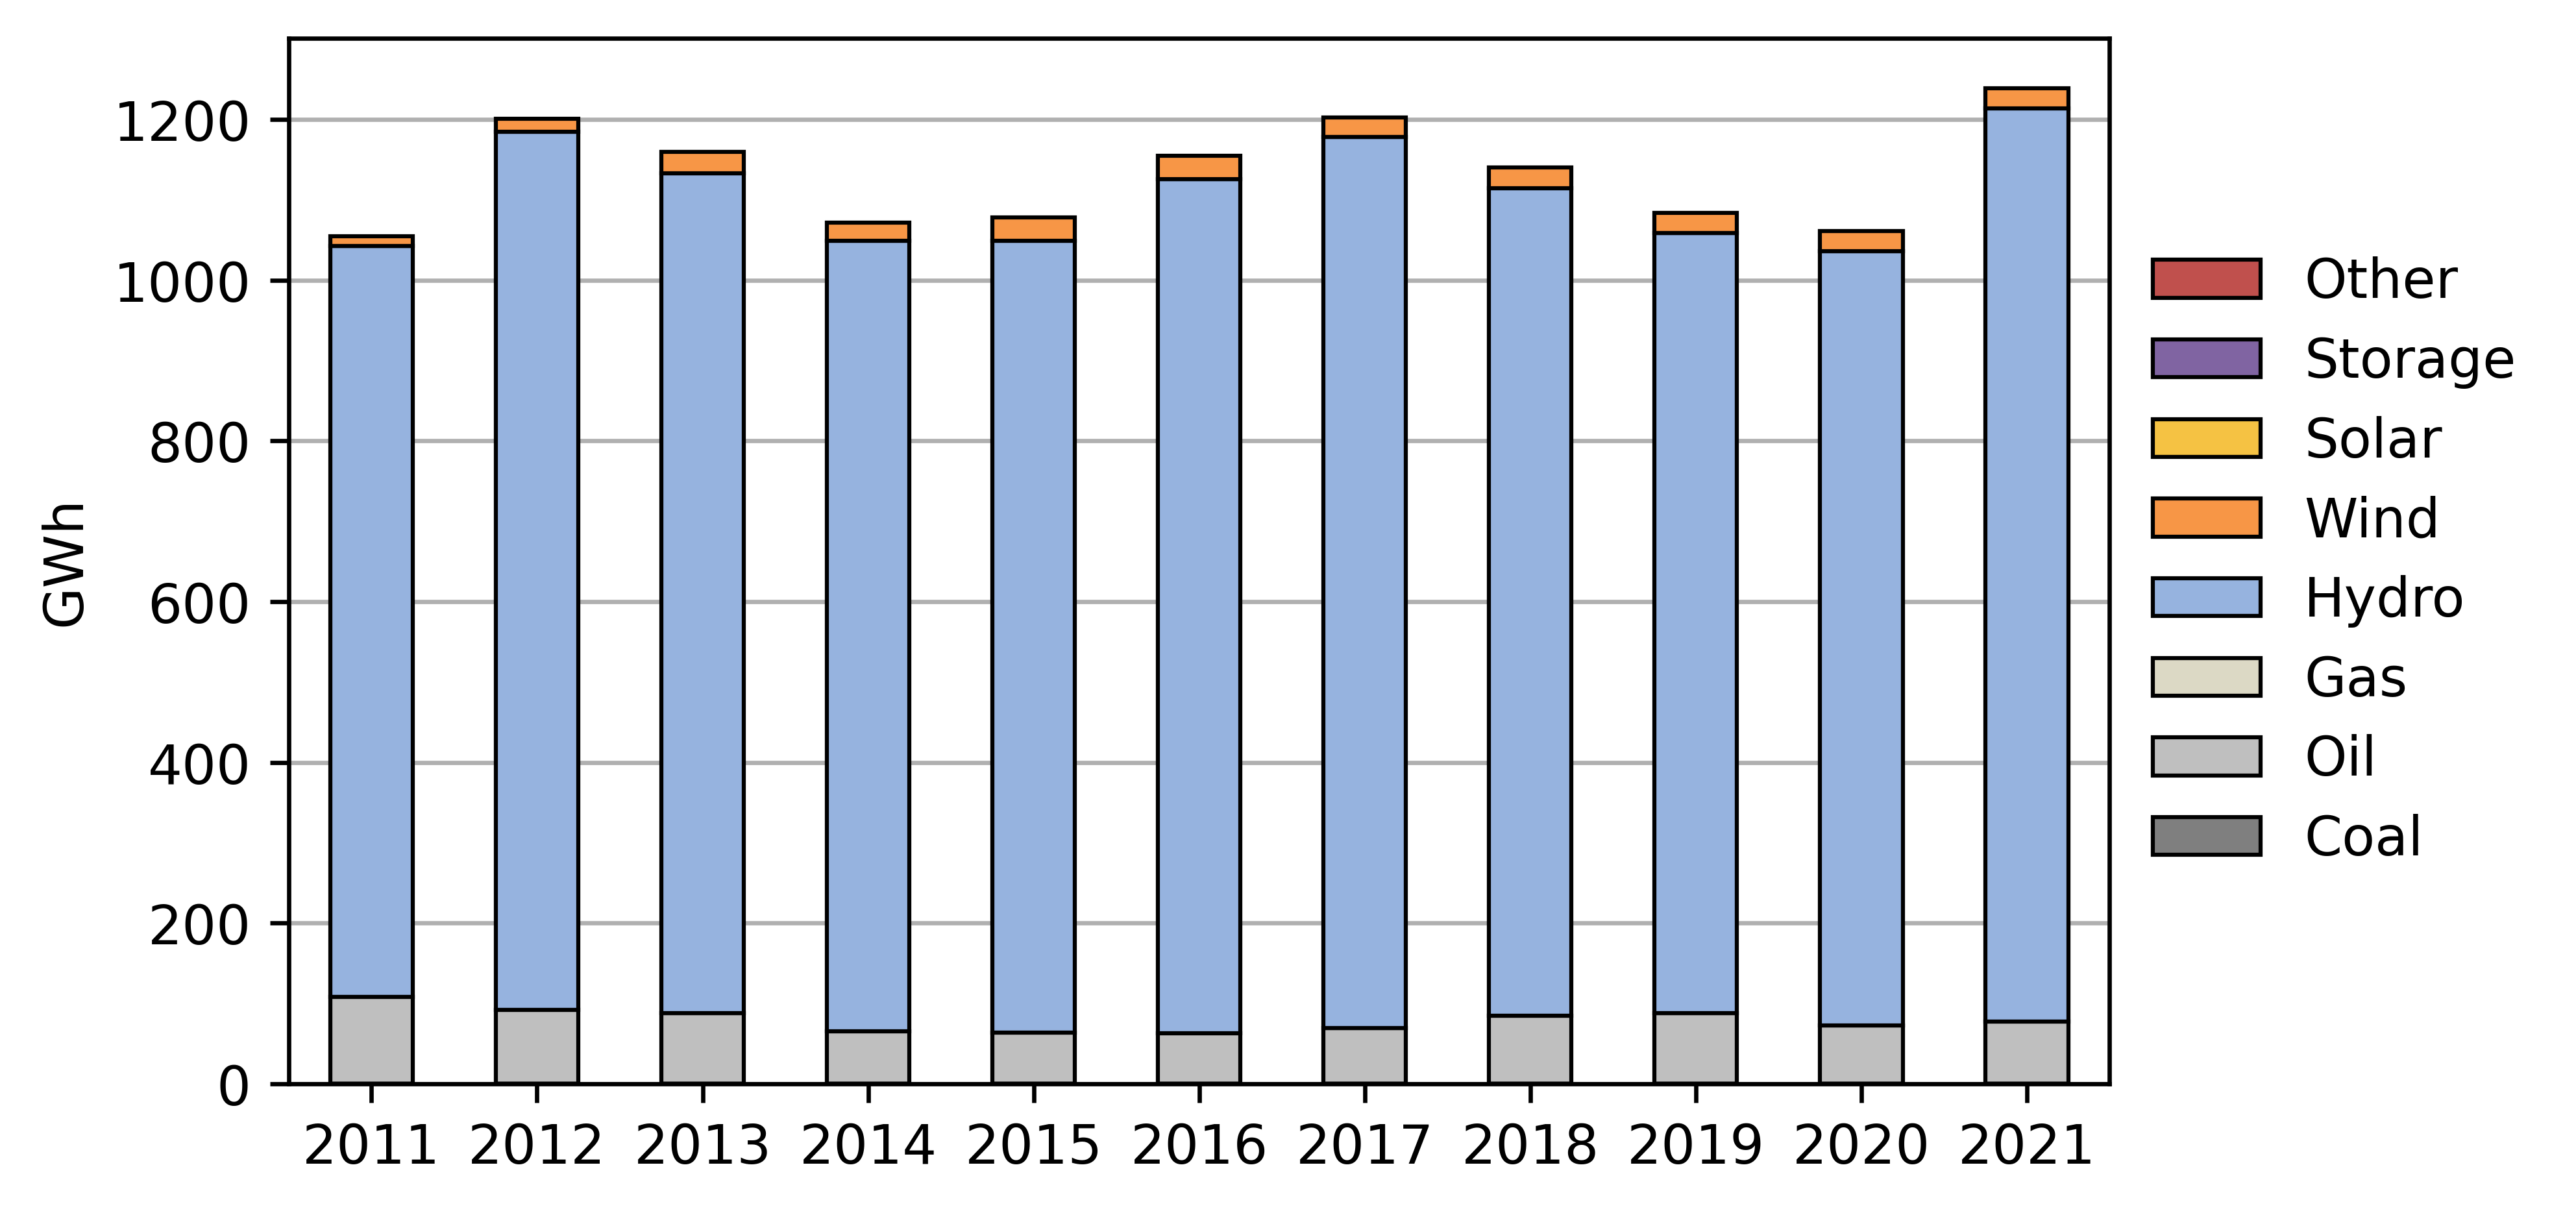

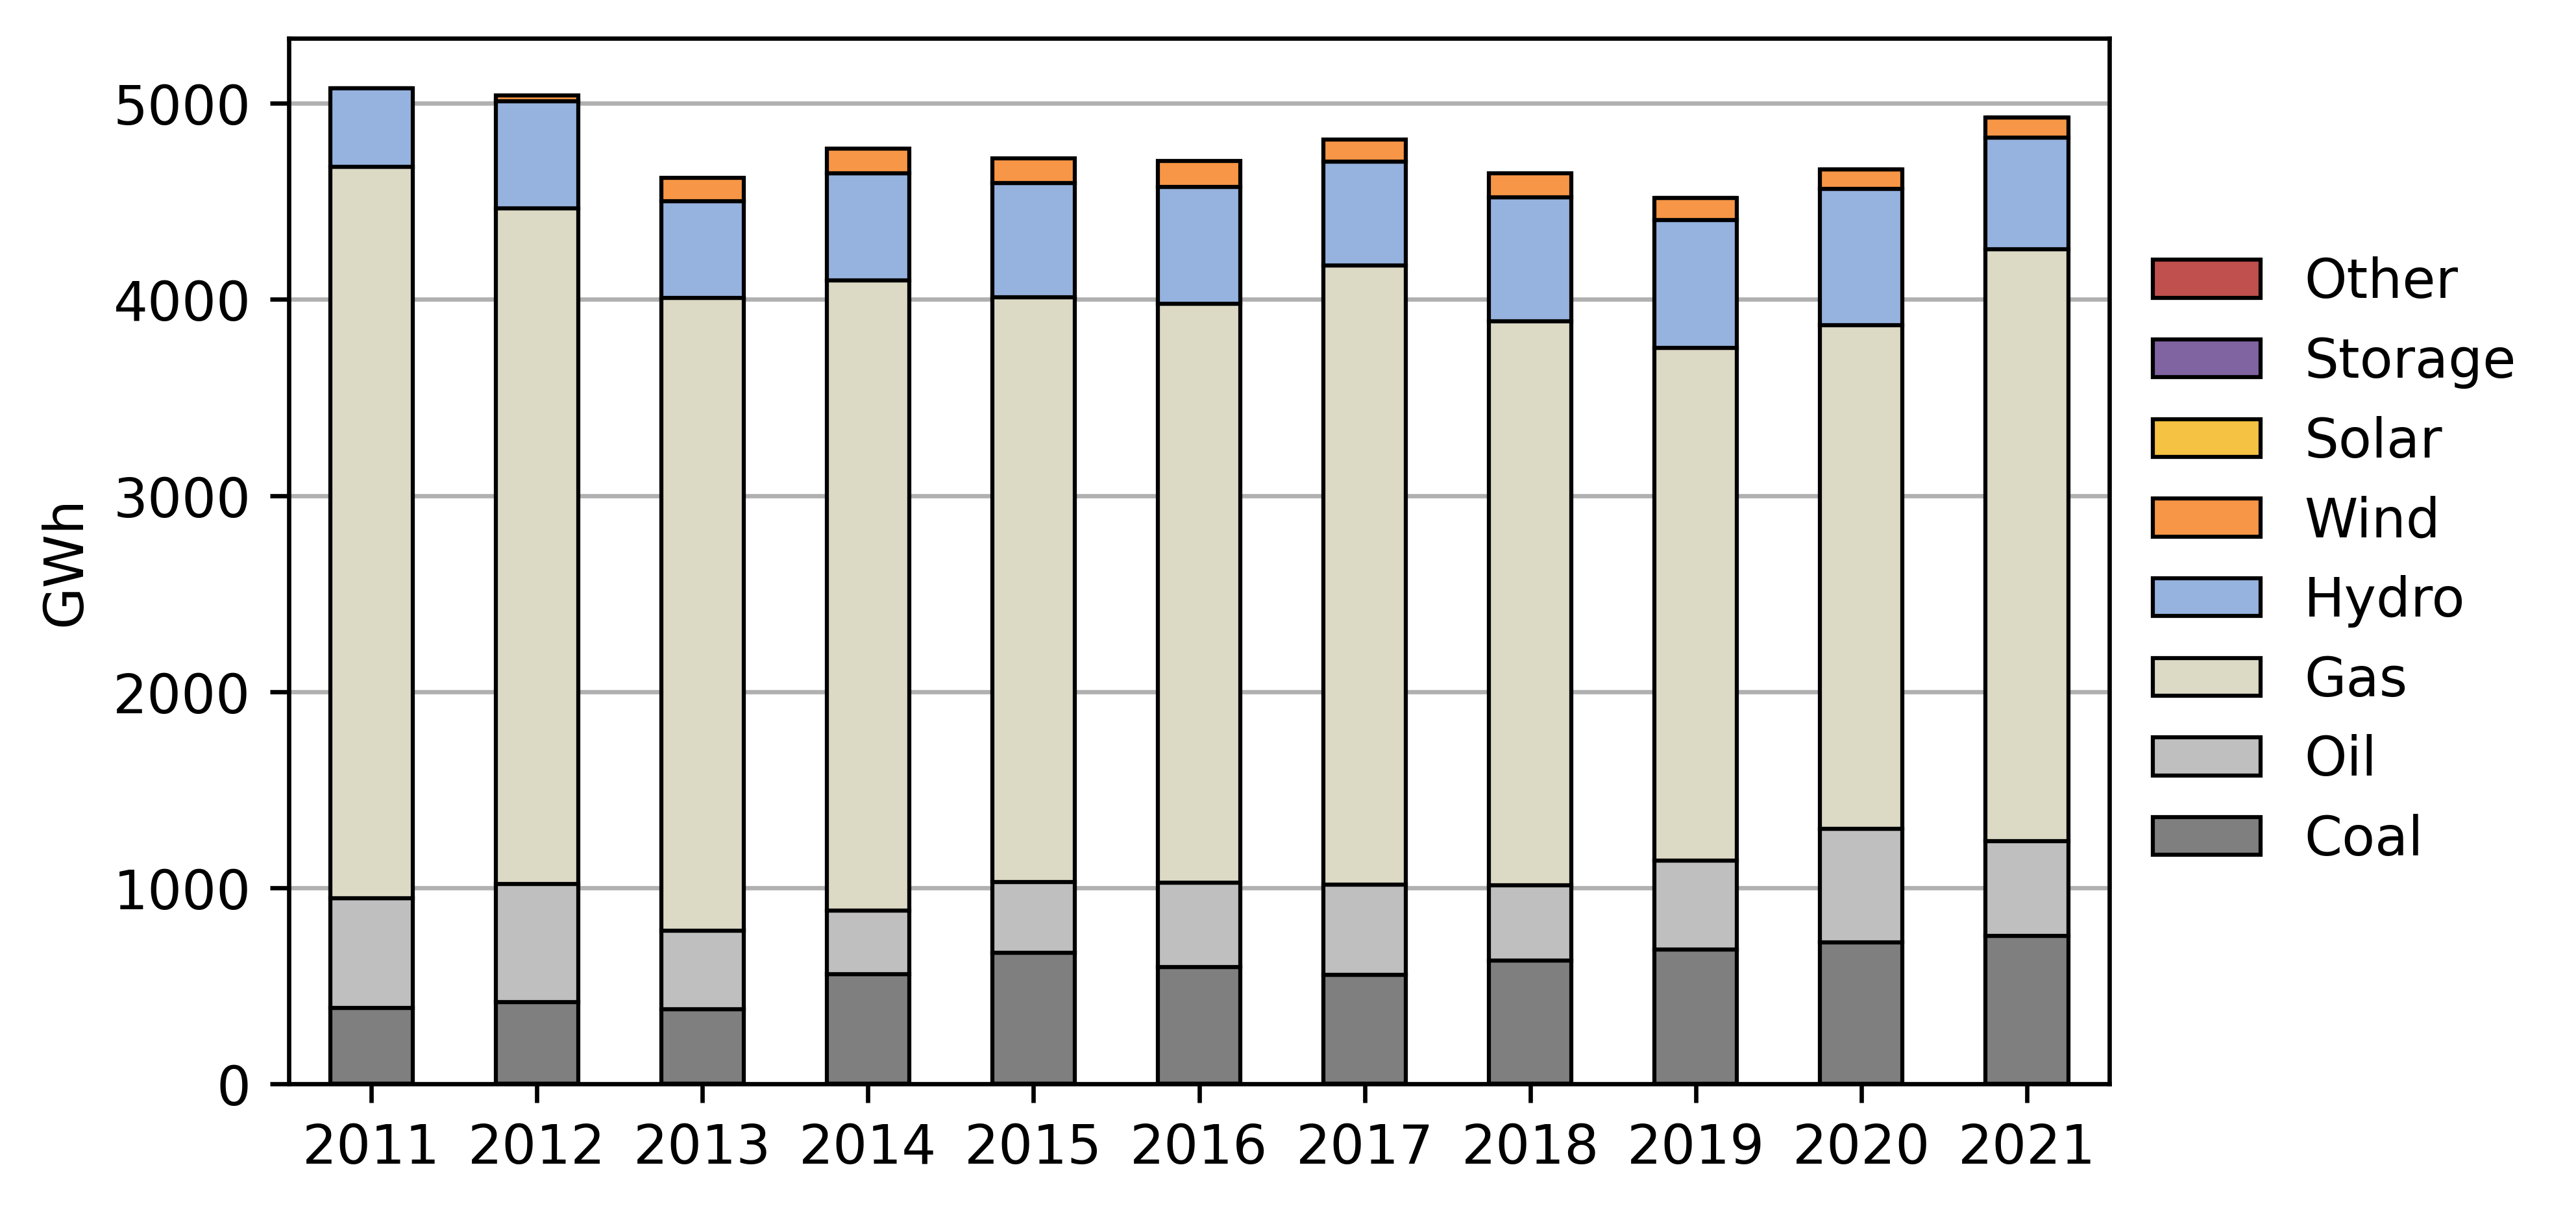

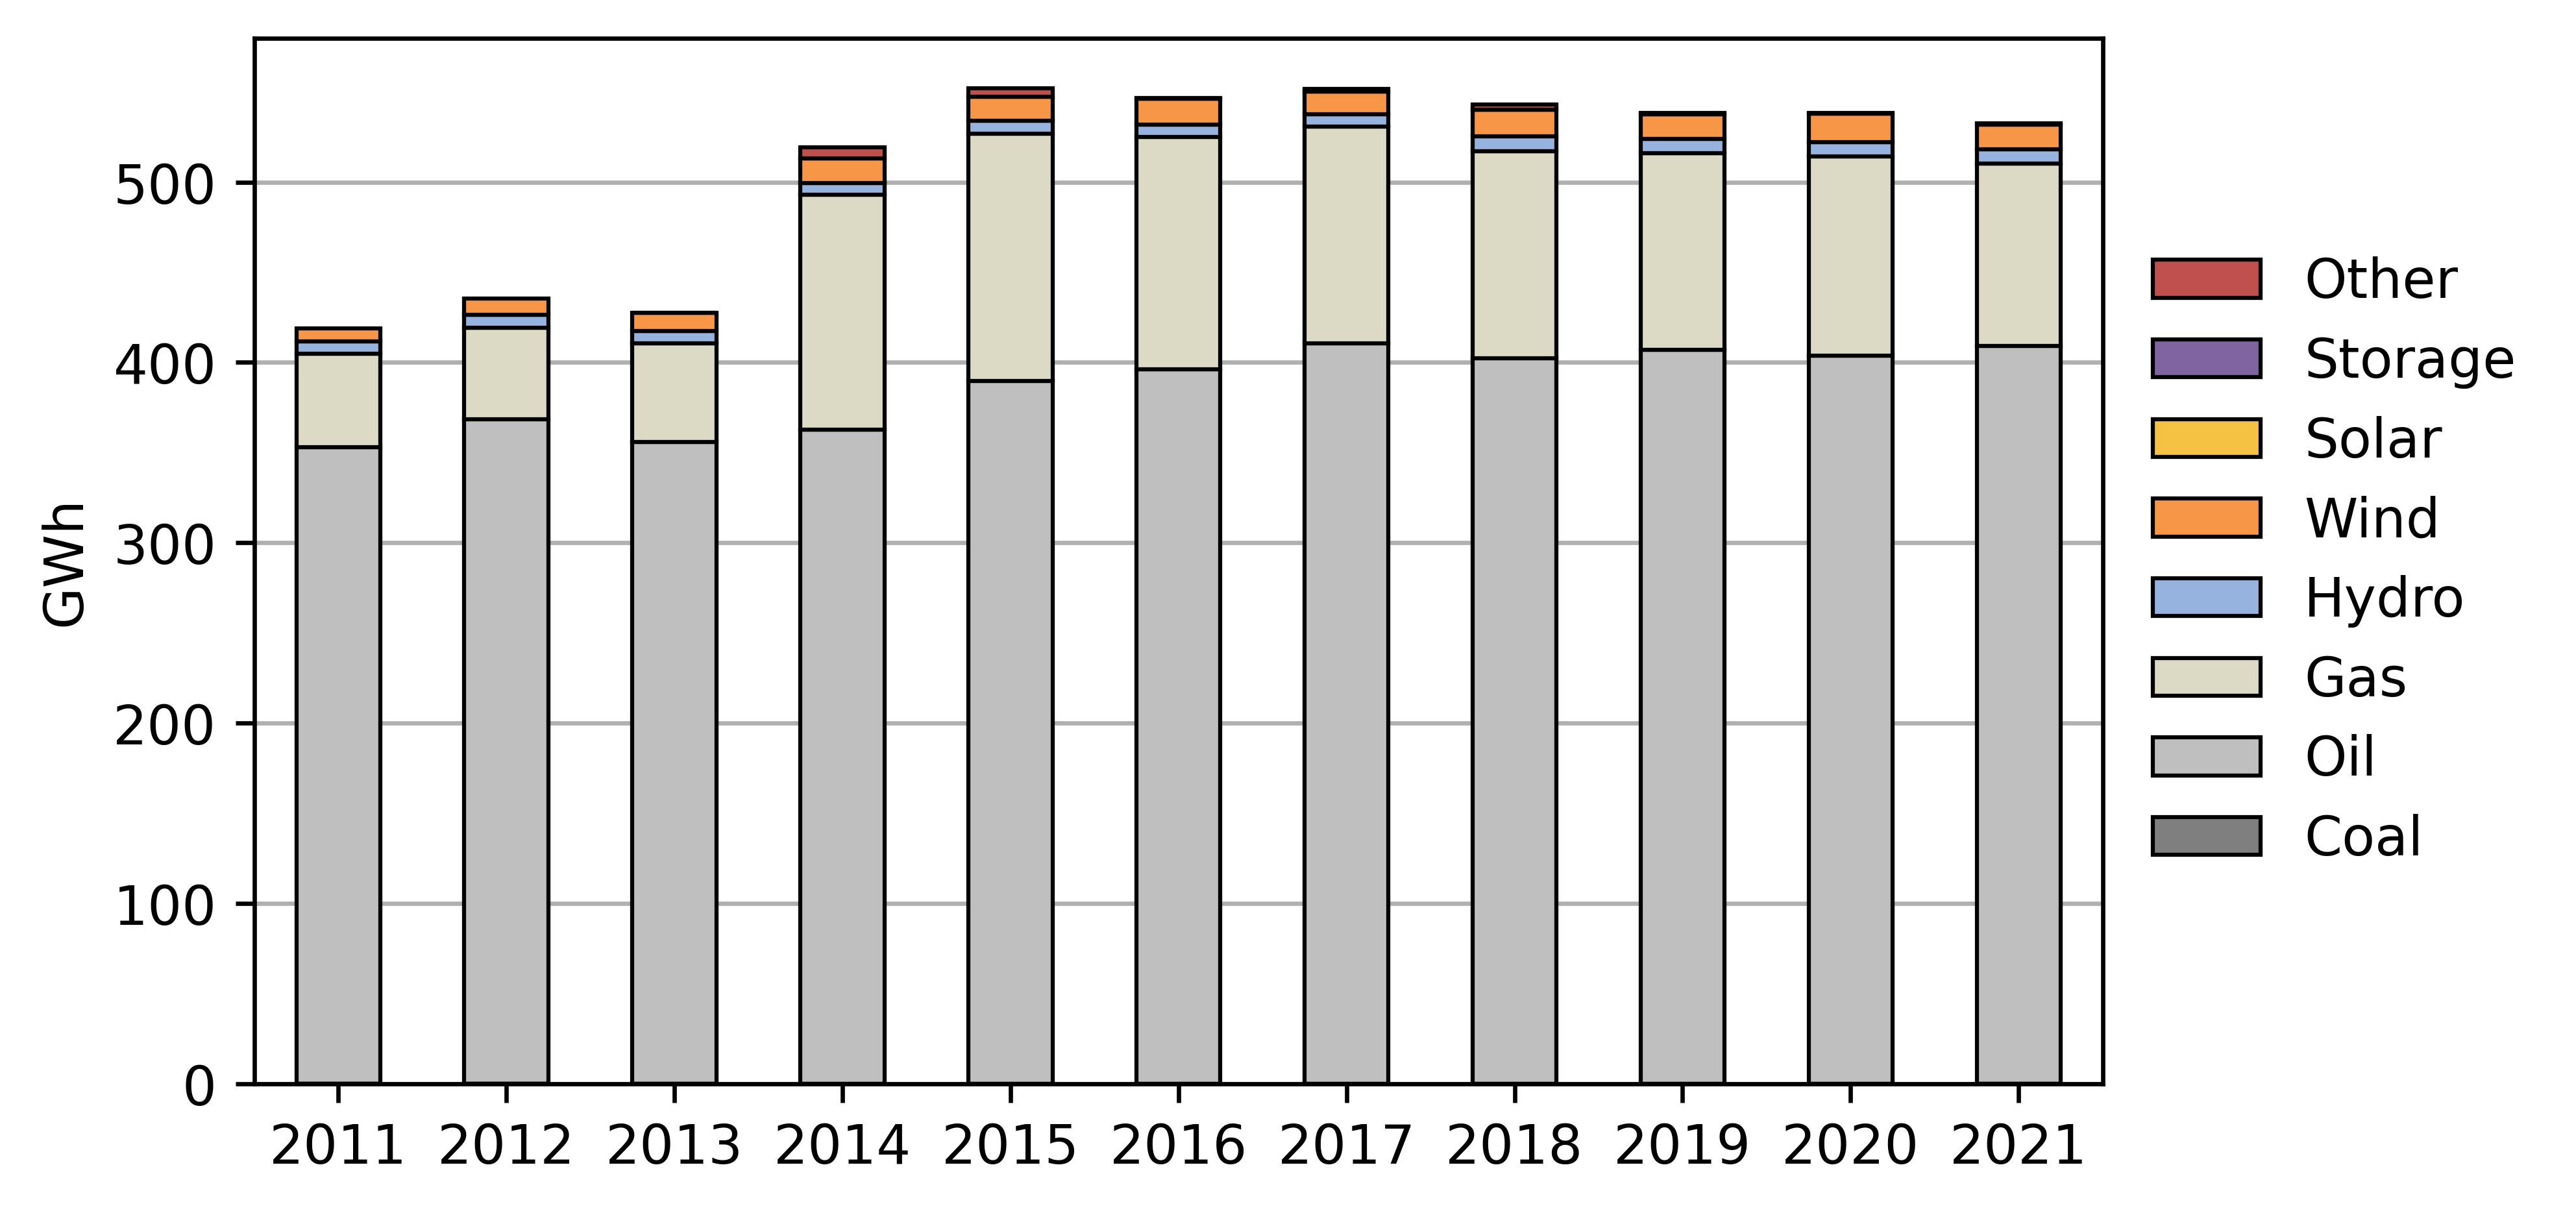

In [12]:
# This section contains code to produce the 2011-2021 annual generation by fuel type for each ACEP energy region

# Preparing the data for plotting
rg = pd.pivot_table(d, index=['acep_energy_region','year'], values=fuel_types + ['total'], aggfunc='sum') # collapsing data on region and year
rg = rg /1000 # convert from MWh to GWh
rg.columns = rg.columns.str.title() # pretty the headers
rg.reset_index(inplace=True)

# Plotting the regional data
resource_list = ['Coal','Oil','Gas','Hydro','Wind','Solar','Storage','Other']
for i in rg['acep_energy_region'].unique():
    fig, ax = plt.subplots(figsize=(6.5,3), layout='constrained')
    fig.set_dpi(600)
    rg[rg['acep_energy_region'] == i].plot(kind='bar', stacked=True, x='year', y=resource_list, color = schemes['fuel_types'],rot=0, edgecolor='black', linewidth=0.75, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('GWh')
    ax.grid(axis ='y')
    ax.set_axisbelow(True)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1, frameon=False)
    ax.set_ylim(ymin=0)
    filename = i.lower().replace(' ','-')  + '-gen'
    plt.savefig(os.path.join(os.curdir, 'figures', filename + '.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(os.curdir, 'figures', filename + '.png'), bbox_inches='tight')

## Regional Tables

In [13]:
# Producing the pivot table for the data appendix
rg = rg[['acep_energy_region','year','Coal','Oil','Gas','Hydro','Solar','Storage','Other','Total']]

for i in rg['acep_energy_region'].unique().tolist():
    rg[rg['acep_energy_region'] == i].iloc[:,1:].round(2).to_csv(os.path.join(os.curdir,'tables',i.lower().replace(' ','-') + '-gen-fuel-type-gwh.csv'), index=False)


### Regional trend statistics

In [14]:
# Cumulative compound annual growth rates (CAGR) for net generation to estimate average yearly growth rate between 2011 and 2021
print('AVERAGE GROWTH RATE PER YEAR')
for i in e.columns.to_list()[1:]:
    print(i.replace(' (GWh)',':'), round(((e[i][10] / e[i][0])**(1 / (10)) - 1)*100,2),'%')


AVERAGE GROWTH RATE PER YEAR
Coastal: 1.62 %
Railbelt: -0.31 %
Rural Remote: 2.43 %
Statewide: 0.22 %


# Shared Area Charts

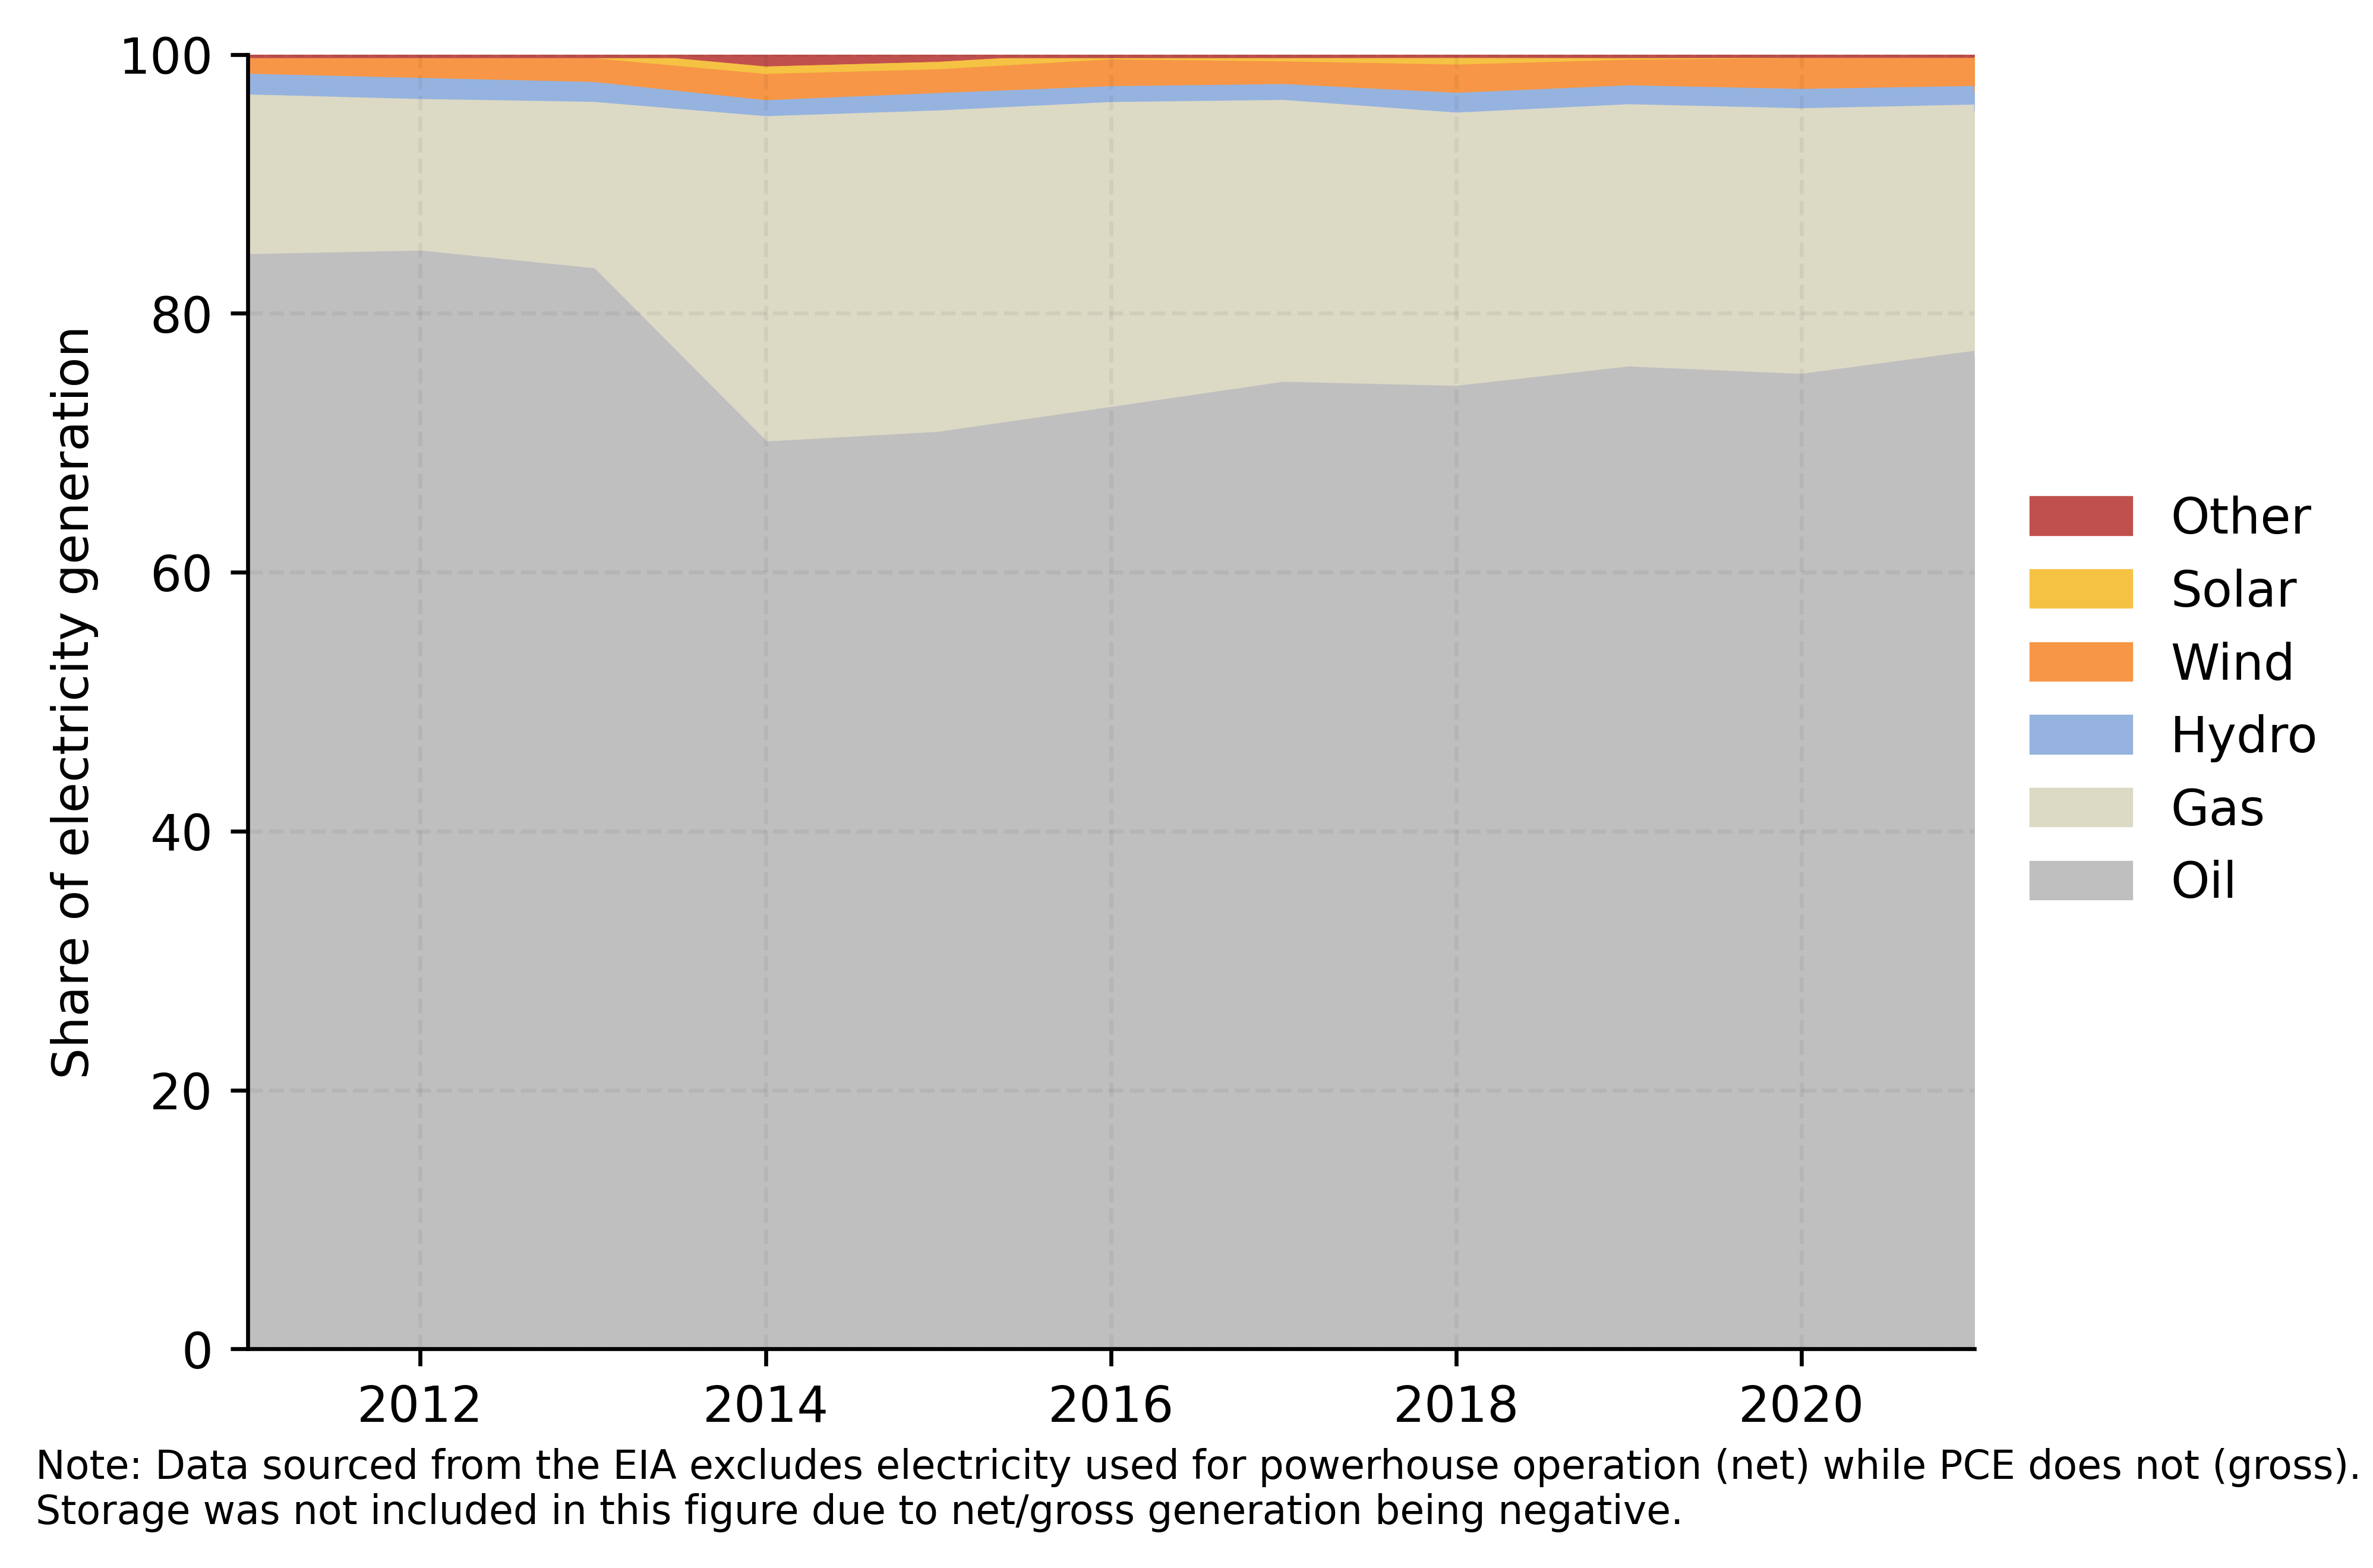

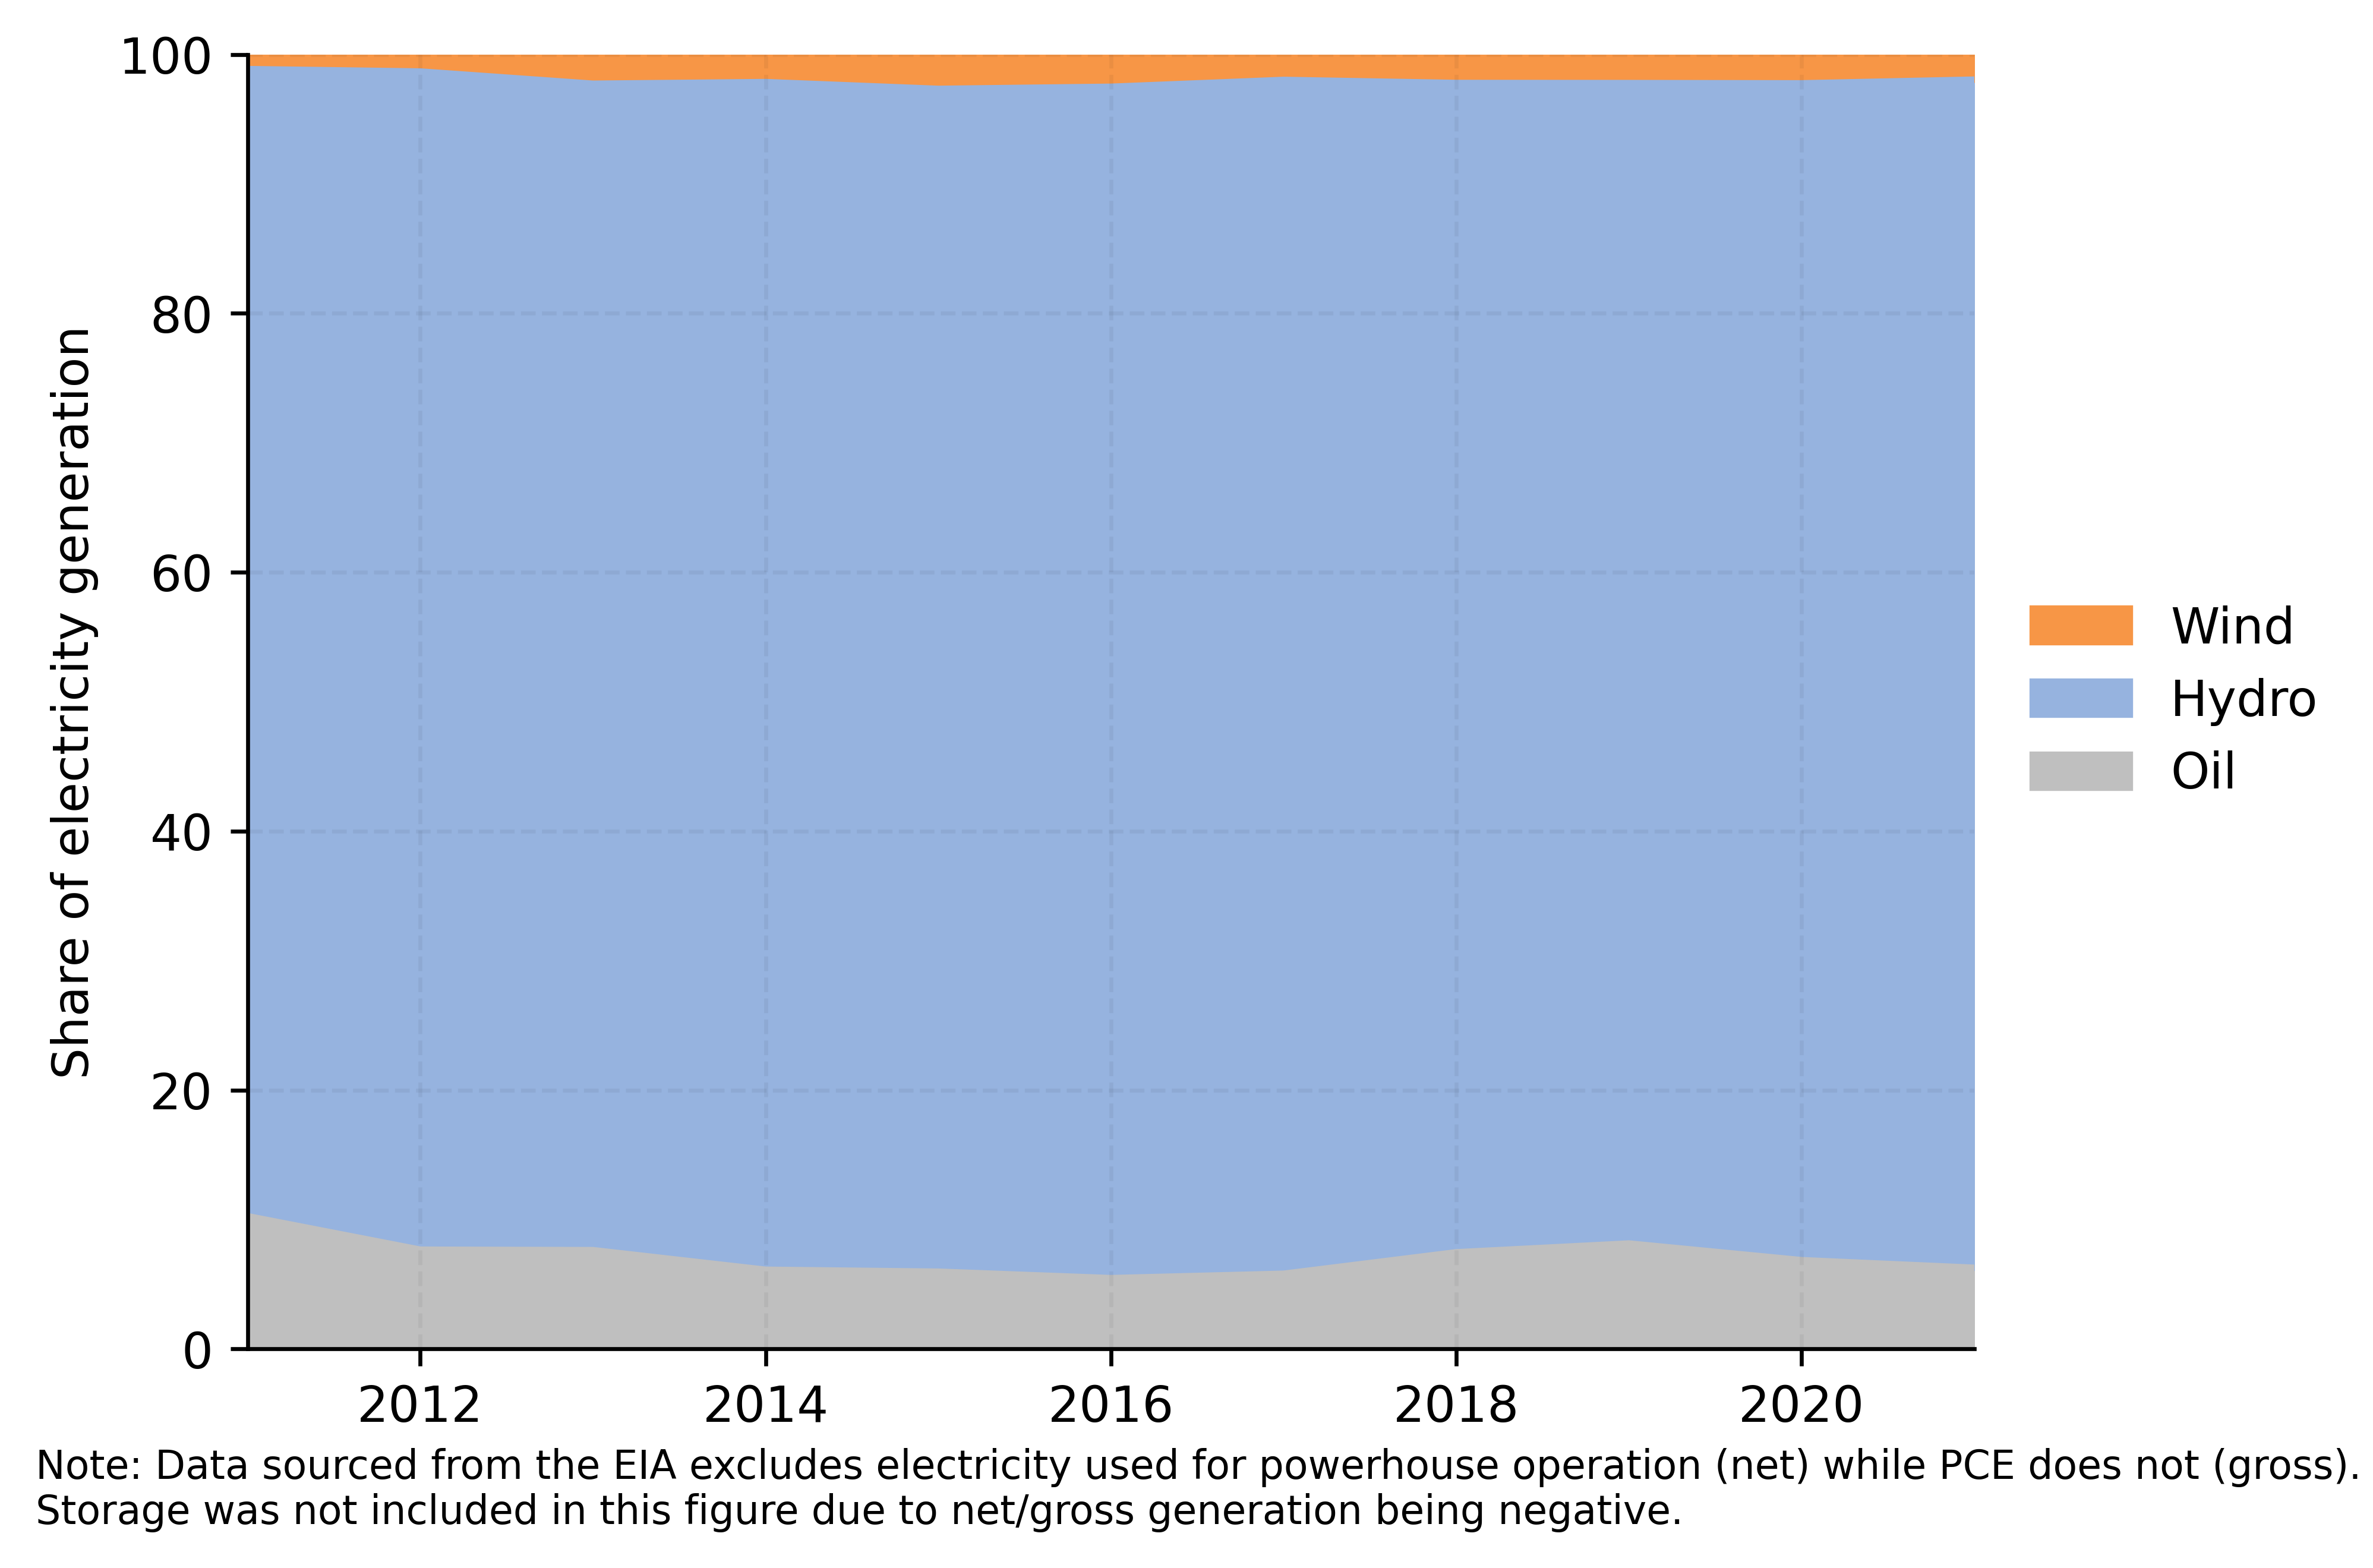

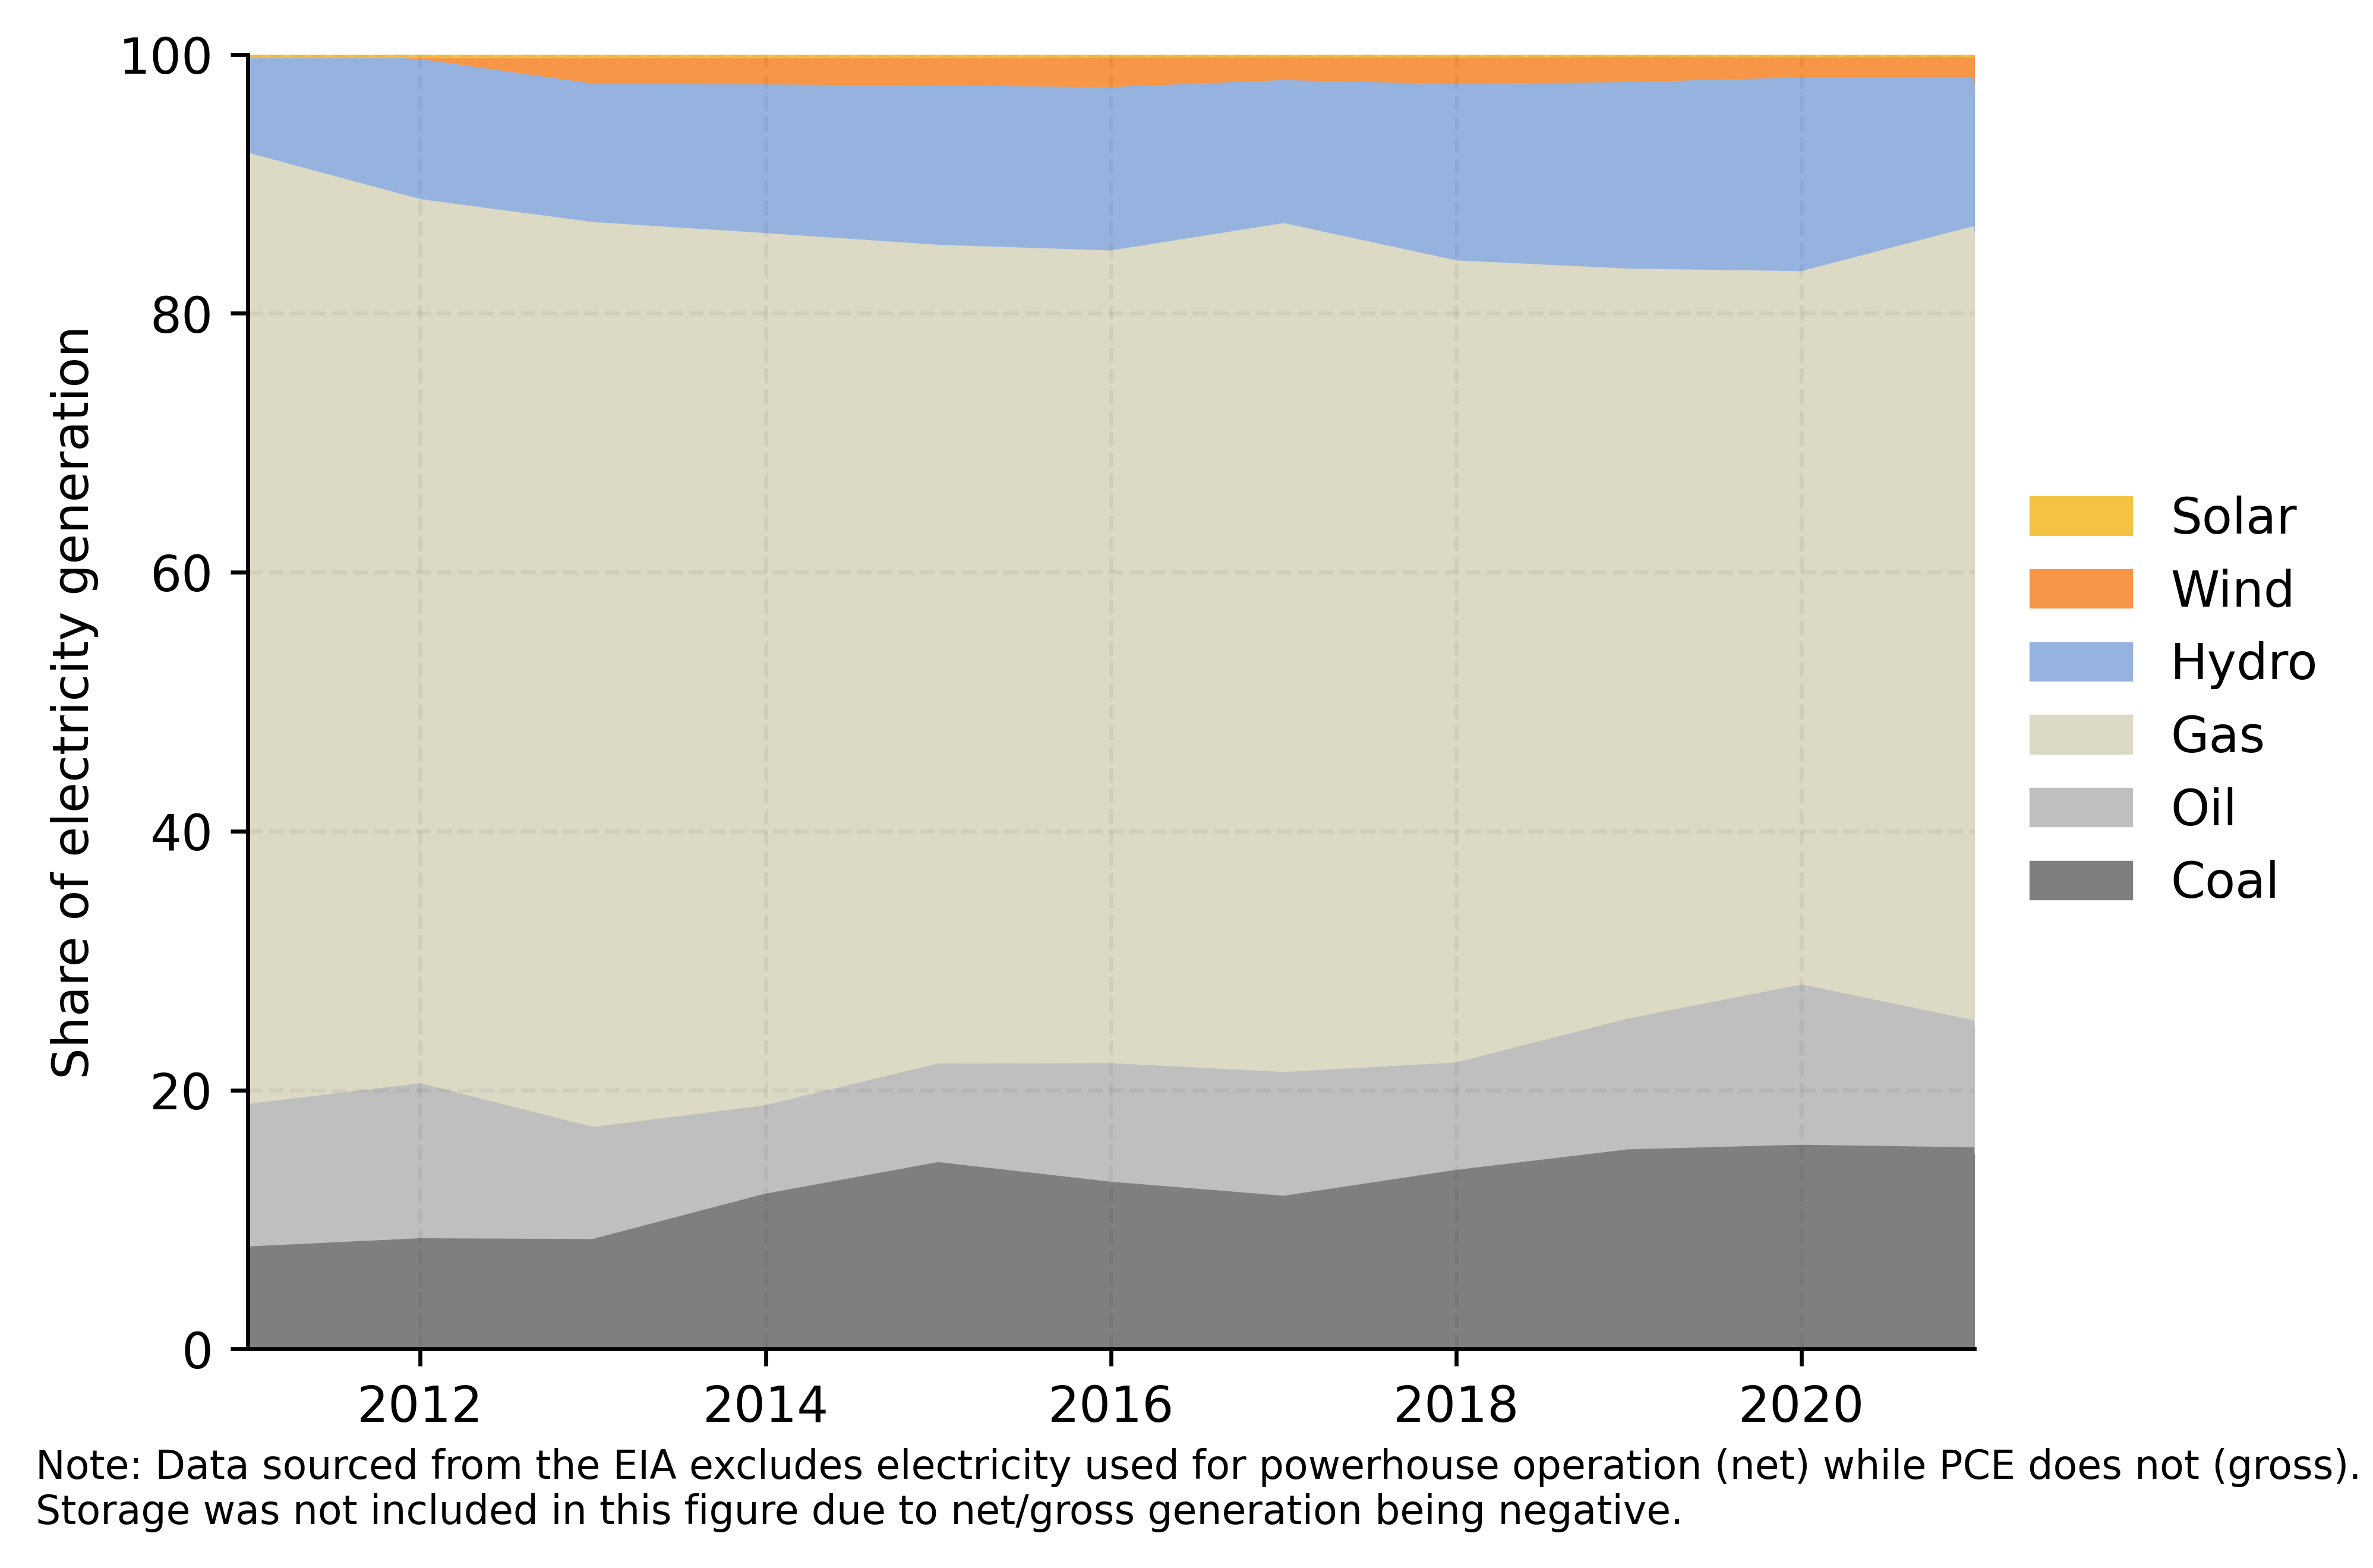

In [25]:
# This code block generates the shared area charts for net generation by fuel type for each region
# It ensures that the labels are properly ordered, and it only plots labels for fuel types used in each region.
#

for i in d['acep_energy_region'].unique():
    
    ## Preamble
    ### Dictionary to sort the resource list (thanks to https://stackoverflow.com/a/16841851)
    fuel_sort_dict = dict((v, i) for i, v in enumerate(['Coal','Oil','Gas','Hydro','Wind','Solar','Storage','Other']))
    
    # Create a slice of the dataframe for each region
    t = pd.pivot_table(d[d['acep_energy_region'] == i],
        index = 'year',
        values = d.columns.tolist()[2:10],
        aggfunc = 'sum'
    )
    t.columns = t.columns.str.title() # capitalize the column headers

    # Create a dynamic list of resources for plotting, automatically removes storage from the fuel mix
    dpl = []
    for x in t.columns.tolist():
        if t[x].sum() > 0:
            dpl += [x]
        else:
            pass
    dpl = sorted(dpl, key=lambda v: fuel_sort_dict.get(v))
    ncol_scalar = len(dpl)
    
    # Convert the dataframe elements from generation (MWh) to share of yearly total generation (%)
    t = t.divide(t.sum(axis=1),axis=0)
    round(t,2).to_csv(os.path.join(os.curdir, 'tables', i.lower().replace(' ','-') + '-generation-mix.csv')) # export the data as shares for appendix
    t = t*100 # convert for better plotting visual

    # Plot and save the figure
    fig, ax = plt.subplots(figsize=(6.5,4), layout='constrained')
    fig.set_dpi(600)
    #fig.patch.set_linewidth(2)
    #fig.patch.set_edgecolor('#0084c1')
    #fig.suptitle(i.title() + " Region Electricity Generation by Fuel Type",fontsize=10, weight='bold', x=0, ha='left')
    #plt.title("Net/Gross Generation, 2011 to 2021", ha='left', loc='left', fontsize=8, color='grey', weight='bold', pad=20, x=-0.0865)
    t.plot(kind='area', stacked=True, y=dpl, color = schemes['fuel_types'], rot=0, alpha=1, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('Share of electricity generation')
    ax.grid(axis ='both',linestyle='--',color='black', alpha=0.05)
    ax.set_axisbelow(False)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='center right', bbox_to_anchor=(1.225, 0.5), frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.tick_params(axis='both', labelsize=8)
    ax.set_ylim(ymax=100)
    caption = 'Note: Data sourced from the EIA excludes electricity used for powerhouse operation (net) while PCE does not (gross). Storage was not included in this figure due to net/gross generation being negative.'
    plt.figtext(0,-0.05,caption,wrap=True,ha='left',fontsize=8)
    plt.margins(0,0)
    filename = i.lower().replace(' ','-')  + '-gen-stacked-area'
    plt.savefig(os.path.join(os.curdir, 'figures', filename + '.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(os.curdir, 'figures', filename + '.png'), bbox_inches='tight')
    